In [32]:
from data import SSHBatchGenerator, NoiseGenerator
from gan import GAN
from models import cgan_disc, cgan_gen
import plots
import xarray as xr
%matplotlib inline
%load_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Visualization

#### Duacs and Swot SSH

Merged together in subset_merge_swot_duacs_1y.nc
The variable ssha corresponds to SWOT, sla corresponds to DUACS

In [4]:
ds = xr.open_dataset('/home/julaja/NS9602/project/foccus/swotai/subset_merge_swot_duacs_1y.nc')
ssha = ds['ssha'].values
sla = ds['sla'].values

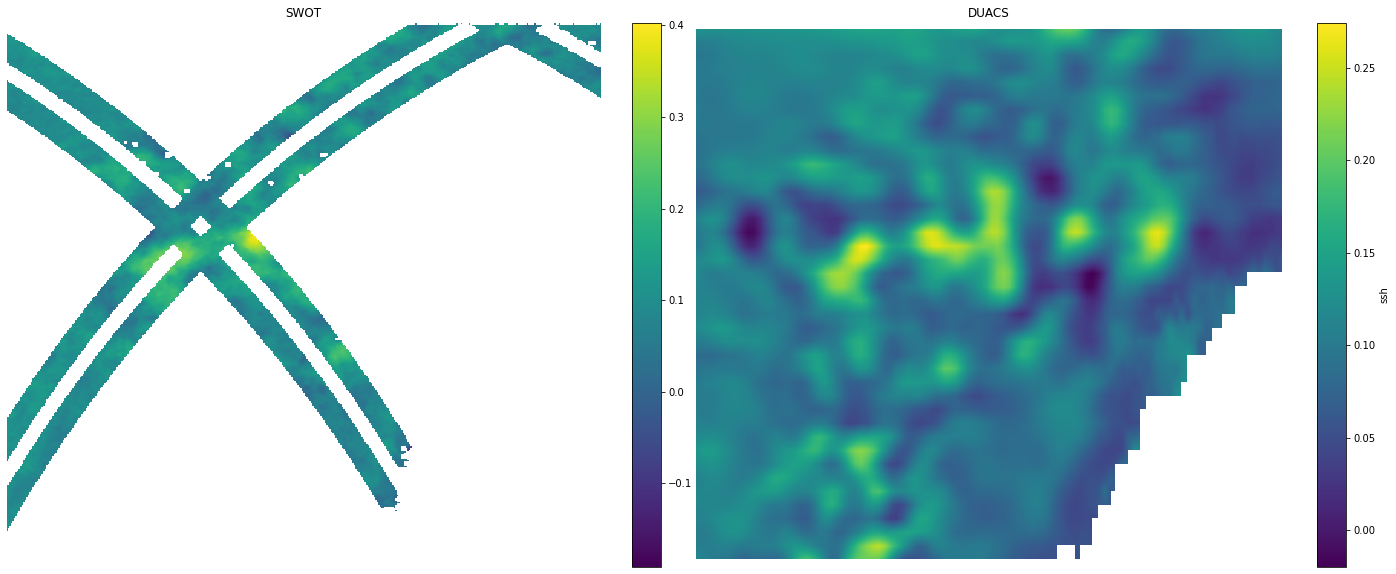

In [42]:
fig = plt.figure(figsize=(24, 10))
gs = GridSpec(1, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.1)

# Plot the original image in the first column
ax1 = fig.add_subplot(gs[0, 0])
cax1 = ax1.imshow(ssha[0], cmap='viridis', aspect='auto')
ax1.set_title('SWOT')
ax1.axis('off')

# Create the colorbar in the second column
cbar_ax = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(cax1, cax=cbar_ax)
cbar.set_label('ssh')

# Plot the reconstructed image in the third column
ax2 = fig.add_subplot(gs[0, 2])
cax2 = ax2.imshow(sla[0], cmap='viridis', aspect='auto')
ax2.set_title('DUACS')
ax2.axis('off')  # Hide axes

# Create the colorbar in the forth column
cbar_ax = fig.add_subplot(gs[0, 3])
cbar = fig.colorbar(cax2, cax=cbar_ax)
cbar.set_label('ssh')

### Bathymetry and SST

In [35]:
def regrid_xarray_hybrid(data_array, target_shape=(440, 388)):
    # Get the original dimensions
    n_rows, n_cols = data_array.shape
    original_x = np.linspace(120, 240, n_rows)
    original_y = np.linspace(120, 240, n_cols)

    # Create a new xarray DataArray with the original data and coordinates
    original_da = xr.DataArray(data_array, coords={'x': original_x, 'y': original_y}, dims=['x', 'y'])

    # Define the new target coordinates
    target_x = np.linspace(120, 240, target_shape[0])
    target_y = np.linspace(120, 240, target_shape[1])

    # Perform bilinear interpolation where possible
    regridded_da = original_da.interp(x=target_x, y=target_y, method="linear")

    return regridded_da

### NOAA SST

def load_bathy():
        ## Bathymetry
        xr_bathy = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO5/dods')
        bathy = xr_bathy['elev'].data
        area_of_interest = {
            'lat_min': 64,
            'lat_max': 74,
            'lon_min': -5,
            'lon_max': 20
        }
        elev_subset = xr_bathy['elev'].sel(
            Y=slice(area_of_interest['lat_max'], area_of_interest['lat_min']),
            X=slice(area_of_interest['lon_min'], area_of_interest['lon_max'])
        )
        bathy = elev_subset.values
        bathy = regrid_xarray_hybrid(bathy, target_shape=(440, 388)).values
        return bathy
    
bathy = load_bathy()

ds_sst = xr.open_dataset('/home/julaja/Antoine/FOCUS/test/data/DMI_sst_nomean.nc')
sst = ds_sst['analysed_sst'].values

### Topaz SST

bathy_tp5  = np.load('/home/julaja/Antoine/FOCUS/test/data/masked_bathy_tp5_data.npy')
mask_tp5 = np.load('/home/julaja/Antoine/FOCUS/test/data/masked_bathy_tp5_mask.npy')

# Reconstruct the masked array
masked_bathy_tp5 = np.ma.masked_array(bathy_tp5, mask_tp5)

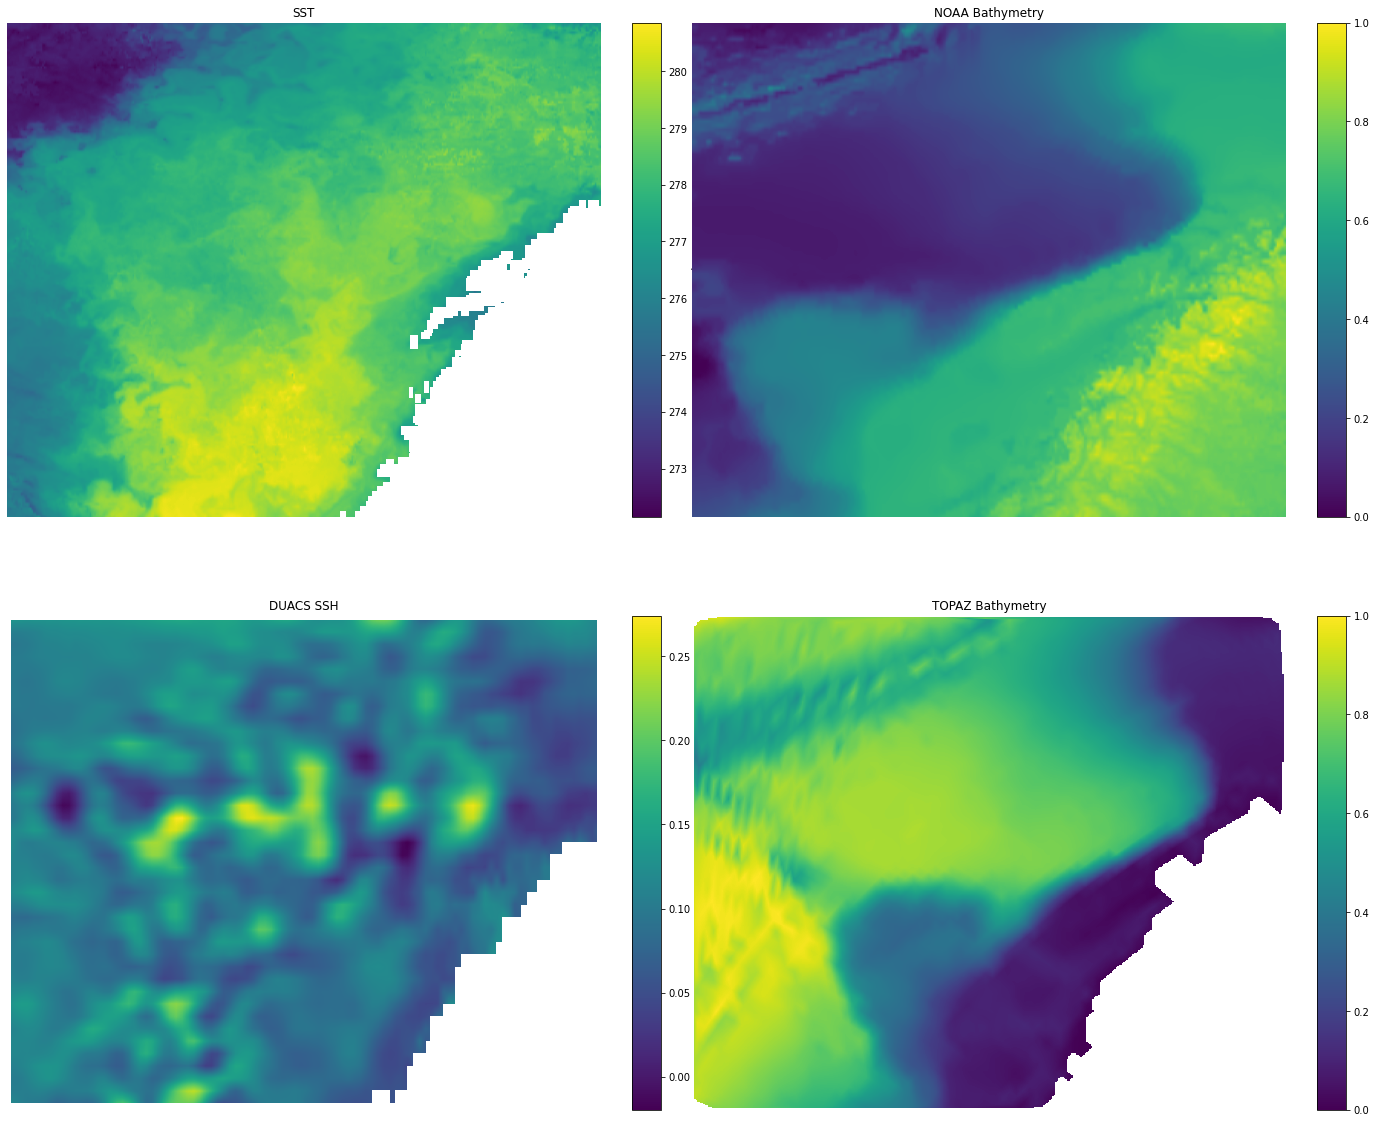

In [41]:
fig = plt.figure(figsize=(24, 20))
gs = GridSpec(2, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.1)

masked_bathy_tp5_norm = (masked_bathy_tp5 - np.min(masked_bathy_tp5)) / (np.max(masked_bathy_tp5) - np.min(masked_bathy_tp5))
bathy_norm = (bathy - np.min(bathy)) / (np.max(bathy) - np.min(bathy))

# Plot the original image in the first column
ax1 = fig.add_subplot(gs[0, 0])
cax1 = ax1.imshow(sst[0], cmap='viridis', aspect='auto')
ax1.set_title('SST')
ax1.axis('off')

# Create the colorbar in the second column
cbar_ax = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(cax1, cax=cbar_ax)
cbar.set_label('ssh')

# Plot the reconstructed image in the third column
ax2 = fig.add_subplot(gs[0, 2])
cax2 = ax2.imshow(bathy_norm, cmap='viridis', aspect='auto')
ax2.set_title('normalized NOAA Bathymetry')
ax2.axis('off')  # Hide axes

# Create the colorbar in the forth column
cbar_ax = fig.add_subplot(gs[0, 3])
cbar = fig.colorbar(cax2, cax=cbar_ax)
cbar.set_label('')

# Plot the original image in the first column
ax1 = fig.add_subplot(gs[1, 0])
cax1 = ax1.imshow(sla[0], cmap='viridis', aspect='auto')
ax1.set_title('DUACS SSH')
ax1.axis('off')

# Create the colorbar in the second column
cbar_ax = fig.add_subplot(gs[1, 1])
cbar = fig.colorbar(cax1, cax=cbar_ax)
cbar.set_label('ssh')

# Plot the reconstructed image in the third column
ax2 = fig.add_subplot(gs[1, 2])
cax2 = ax2.imshow(masked_bathy_tp5_norm, cmap='viridis', aspect='auto', origin='lower')
ax2.set_title('normalized TOPAZ Bathymetry')
ax2.axis('off')  # Hide axes

# Create the colorbar in the forth column
cbar_ax = fig.add_subplot(gs[1, 3])
cbar = fig.colorbar(cax2, cax=cbar_ax)
cbar.set_label('')

# Inference

### Load the NN

In [17]:
from tensorflow.keras.models import load_model
import numpy as np

weights_path = "weights/generator_weights_018_nomean_denorm_96-48-20-80.h5"  # Modify with your actual weights file

noise_dim = 1024
im_shape = (48,48,1)
cond_shape = (96,96,1)
gen = cgan_gen(im_shape, cond_shape, noise_dim=noise_dim)
noise_gen = NoiseGenerator([(noise_dim,)])
gen.load_weights(weights_path)

### Load the date you want to super resolve

In [19]:
ds_ini = xr.open_dataset('/home/julaja/NS9602/project/foccus/swotai/subset_merge_swot_duacs_1y.nc')
ds_ini_sst = xr.open_dataset('/home/julaja/Antoine/FOCUS/test/data/DMI_sst_nomean.nc')
ssha_ini = ds_ini['ssha'].values
sla_ini = ds_ini['sla'].values

# Create a mask for NaN values
sla_mask = ~np.isnan(sla_ini)  # 1 for valid, 0 for NaN
ssha_mask = ~np.isnan(ssha_ini)
total_mask = sla_mask & ssha_mask

# Replace NaN values in sla and ssha
sla_ini = np.nan_to_num(sla_ini, nan=0.0)  # Replace NaN with 0 in input
ssha_ini = np.nan_to_num(ssha_ini, nan=0.0)  # Replace NaN with 0 in target

ds_ini.close()

## Choose the date for the inference
date_eval = 430

X_eval = sla_ini[date_eval, :, :]
SWOT_eval = ssha_ini[date_eval, :, :]

### Inference

Padding with 0 around the image,
divide the image into patches and do the inference on this batch of patches,
then reconstruct the full image from the patches

In [27]:
patch_input_size = 96
patch_prediction_size = 48
diff_size = patch_input_size - patch_prediction_size
half_diff_size = diff_size//2
X_eval_padded = np.pad(X_eval, ((half_diff_size, half_diff_size), (half_diff_size, half_diff_size)), mode='constant', constant_values=0)

reconstructed_image = np.zeros(X_eval_padded.shape)

# Prepare a list to store patches and their positions
patches = []
positions = []

# Loop through the image and extract patches
for i in range(half_diff_size, X_eval_padded.shape[0] - half_diff_size - patch_prediction_size + 1, patch_prediction_size):
    for j in range(half_diff_size, X_eval_padded.shape[1] - half_diff_size - patch_prediction_size + 1, patch_prediction_size):
        patch = X_eval_padded[i - half_diff_size: i + patch_prediction_size + half_diff_size, j - half_diff_size: j + patch_prediction_size + half_diff_size] # CONTEXT PATCH
        patches.append(patch)
        positions.append((i, j))  # Save top-left corner position

# Convert patches to a NumPy array (assuming the model expects a batch of 4D input)
patches = np.stack(patches)  # Shape: (batch_size, patch_input_size, patch_input_size)

# Do batch prediction
predicted_patches = plots.predict_images(gen, noise_gen, patches)  # Use batch prediction function

# Reconstruct the image from predicted patches
for (i, j), predicted_patch in zip(positions, predicted_patches):
    reconstructed_image[i : i + patch_prediction_size, j : j + patch_prediction_size] = predicted_patch[:, :, 0]
    
reconstructed_image = reconstructed_image[half_diff_size: -half_diff_size, half_diff_size: -half_diff_size]
reconstructed_image[~sla_mask[0,:]] = 0

### Plot the results

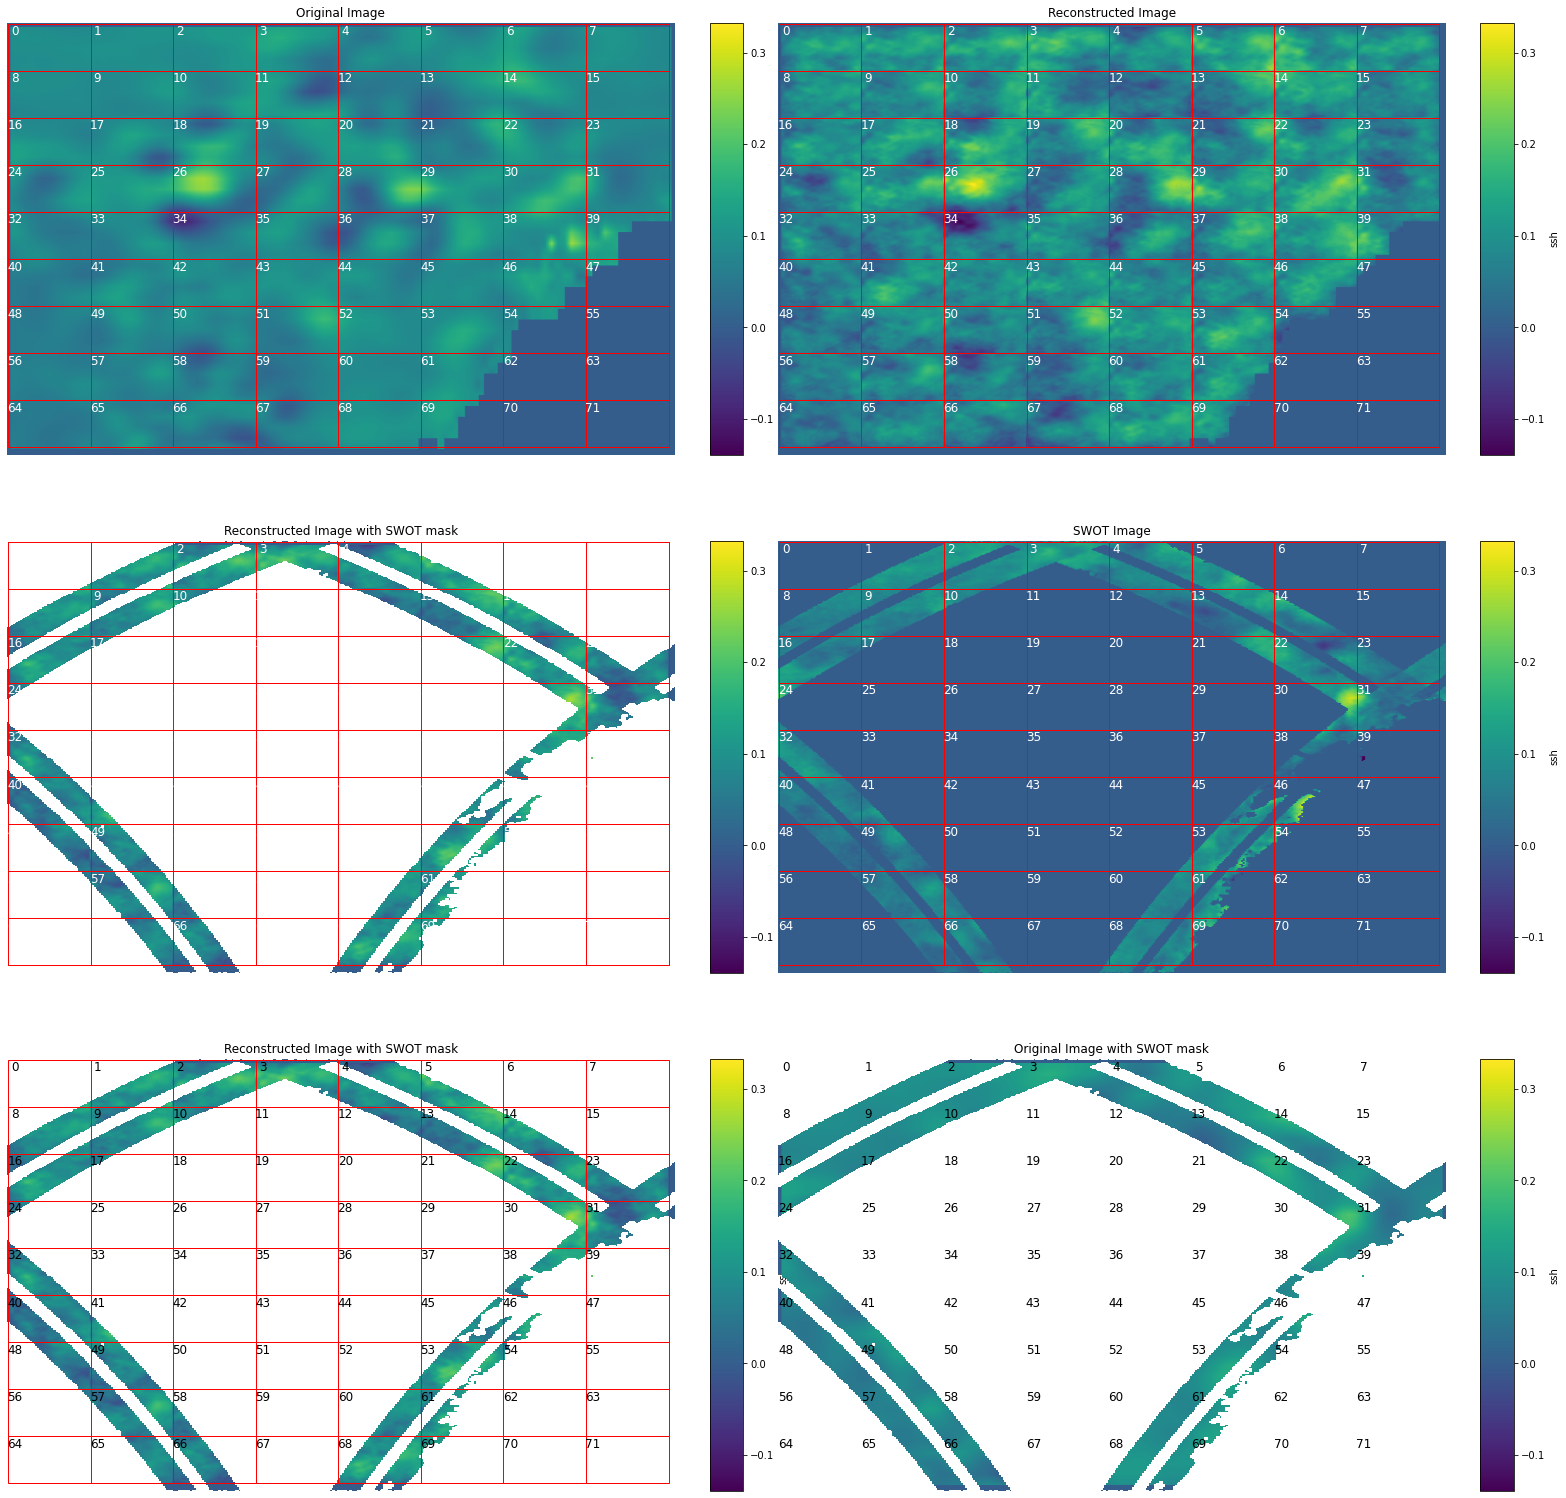

In [31]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
%matplotlib inline

quadrillage = 1
quadrillage_text = 1

vmin = np.min(reconstructed_image)
vmax = np.max(reconstructed_image)
#vmin = np.min(X_eval)
#vmax = np.max(X_eval)
#vmin = -2
#vmax = 2.5

# Create the figure with GridSpec to handle layout manually
fig = plt.figure(figsize=(27, 27))
# Create a GridSpec with 2 columns and room for the colorbar
gs = GridSpec(3, 4, width_ratios=[1, 0.05, 1, 0.05], wspace=0.1)

# Plot the original image in the first column
ax1 = fig.add_subplot(gs[0, 0])
cax1 = ax1.imshow(X_eval, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax1.set_title('Original Image')
ax1.axis('off')  # Hide axes
if quadrillage:
    for idx, (i, j) in enumerate(positions):
        rect = plt.Rectangle((j - half_diff_size, i - half_diff_size), patch_prediction_size, patch_prediction_size,
                             linewidth=1, edgecolor='red', facecolor='none')
        ax1.add_patch(rect)
        if quadrillage_text:
            ax1.text(j - half_diff_size + 4, i - half_diff_size + 8,
                     str(idx), color='white', fontsize=12, ha='center', va='center')
                     #bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))

# Create the colorbar in the third (narrow) column
cbar_ax = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(cax1, cax=cbar_ax)
cbar.set_label('ssh')

# Plot the reconstructed image in the second column
ax2 = fig.add_subplot(gs[0, 2])
cax2 = ax2.imshow(reconstructed_image, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_title('Reconstructed Image')
ax2.axis('off')  # Hide axes

if quadrillage:
    for idx, (i, j) in enumerate(positions):
        rect = plt.Rectangle((j - half_diff_size, i - half_diff_size), patch_prediction_size, patch_prediction_size,
                             linewidth=1, edgecolor='red', facecolor='none')
        ax2.add_patch(rect)
        if quadrillage_text:
            ax2.text(j - half_diff_size + 4, i - half_diff_size + 8,
             str(idx), color='white', fontsize=12, ha='center', va='center')
             #bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))
    
cbar_ax = fig.add_subplot(gs[0, 3])
cbar = fig.colorbar(cax2, cax=cbar_ax)
cbar.set_label('ssh')
    
# Plot the original image in the first column
ax3 = fig.add_subplot(gs[1, 0])
cax3 = ax3.imshow(np.ma.masked_array(reconstructed_image, 1-ssha_mask[date_eval,:]), cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax3.set_title('Reconstructed Image with SWOT mask')
ax3.axis('off')  # Hide axes

if quadrillage:
    for idx, (i, j) in enumerate(positions):
        rect = plt.Rectangle((j - half_diff_size, i - half_diff_size), patch_prediction_size, patch_prediction_size,
                             linewidth=1, edgecolor='red', facecolor='none')
        ax3.add_patch(rect)
        if quadrillage_text:
            ax3.text(j - half_diff_size + 4, i - half_diff_size + 8,
             str(idx), color='white', fontsize=12, ha='center', va='center')
             #bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))

# Create the colorbar in the third (narrow) column
cbar_ax = fig.add_subplot(gs[1, 1])
cbar = fig.colorbar(cax3, cax=cbar_ax)
cbar.set_label('ssh')

# Plot the reconstructed image in the second column
ax4 = fig.add_subplot(gs[1, 2])
cax4 = ax4.imshow(SWOT_eval, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax4.set_title('SWOT Image')
ax4.axis('off')  # Hide axes

if quadrillage:
    for idx, (i, j) in enumerate(positions):
        rect = plt.Rectangle((j - half_diff_size, i - half_diff_size), patch_prediction_size, patch_prediction_size,
                             linewidth=1, edgecolor='red', facecolor='none')
        ax4.add_patch(rect)
        if quadrillage_text:
            ax4.text(j - half_diff_size + 4, i - half_diff_size + 8,
             str(idx), color='white', fontsize=12, ha='center', va='center')
             #bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))
    
# Create the colorbar in the third (narrow) column
cbar_ax = fig.add_subplot(gs[1, 3])
cbar = fig.colorbar(cax4, cax=cbar_ax)
cbar.set_label('ssh')

############### LINE 3
# Plot the original image in the first column
ax4 = fig.add_subplot(gs[2, 0])
cax4 = ax4.imshow(np.ma.masked_array(reconstructed_image, 1-ssha_mask[date_eval,:]), cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax4.set_title('Reconstructed Image with SWOT mask')
ax4.axis('off')  # Hide axes

if quadrillage:
    for idx, (i, j) in enumerate(positions):
        rect = plt.Rectangle((j - half_diff_size, i - half_diff_size), patch_prediction_size, patch_prediction_size,
                             linewidth=1, edgecolor='red', facecolor='none')
        ax3.add_patch(rect)
        if quadrillage_text:
            ax4.text(j - half_diff_size + 4, i - half_diff_size + 8,
             str(idx), color='black', fontsize=12, ha='center', va='center')
             #bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))

# Create the colorbar in the third (narrow) column
cbar_ax = fig.add_subplot(gs[2, 1])
cbar = fig.colorbar(cax4, cax=cbar_ax)
cbar.set_label('ssh')

# Plot the reconstructed image in the second column
ax5 = fig.add_subplot(gs[2, 2])
cax5 = ax5.imshow(np.ma.masked_array(X_eval, 1-ssha_mask[date_eval,:]), cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax5.set_title('Original Image with SWOT mask')
ax5.axis('off')  # Hide axes

if quadrillage:
    for idx, (i, j) in enumerate(positions):
        rect = plt.Rectangle((j - half_diff_size, i - half_diff_size), patch_prediction_size, patch_prediction_size,
                             linewidth=1, edgecolor='red', facecolor='none')
        ax4.add_patch(rect)
        if quadrillage_text:
            ax5.text(j - half_diff_size + 4, i - half_diff_size + 8,
             str(idx), color='black', fontsize=12, ha='center', va='center')
             #bbox=dict(facecolor='red', edgecolor='none', boxstyle='round,pad=0.2'))
    
# Create the colorbar in the third (narrow) column
cbar_ax = fig.add_subplot(gs[2, 3])
cbar = fig.colorbar(cax5, cax=cbar_ax)
cbar.set_label('ssh')

# Show the plot
plt.show()

# Metrics for comparaison

### 1D Spectral Power

In [49]:
import numpy as np
from scipy.stats import binned_statistic
from skimage.draw import line

def line_power_spectrum(image, start, end, normalize=None):
    rr, cc = line(start[0], start[1], end[0], end[1])
    line_values = image[rr, cc]

    if normalize == 'Mean':
        line_values = line_values / np.mean(line_values)  # Multiplicative normalization
    if normalize == 'CR':
        line_values = (line_values - np.mean(line_values)) / np.std(line_values)
    

    fourier_line = np.fft.fft(line_values)
    power_spectrum = np.abs(fourier_line) ** 2

    n = len(line_values)
    kfreq = np.fft.fftfreq(n) * n
    kfreq = np.abs(kfreq)

    kbins = np.arange(0.5, n / 2, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = binned_statistic(kfreq, power_spectrum, statistic="mean", bins=kbins)

    return kvals, Abins, line_values

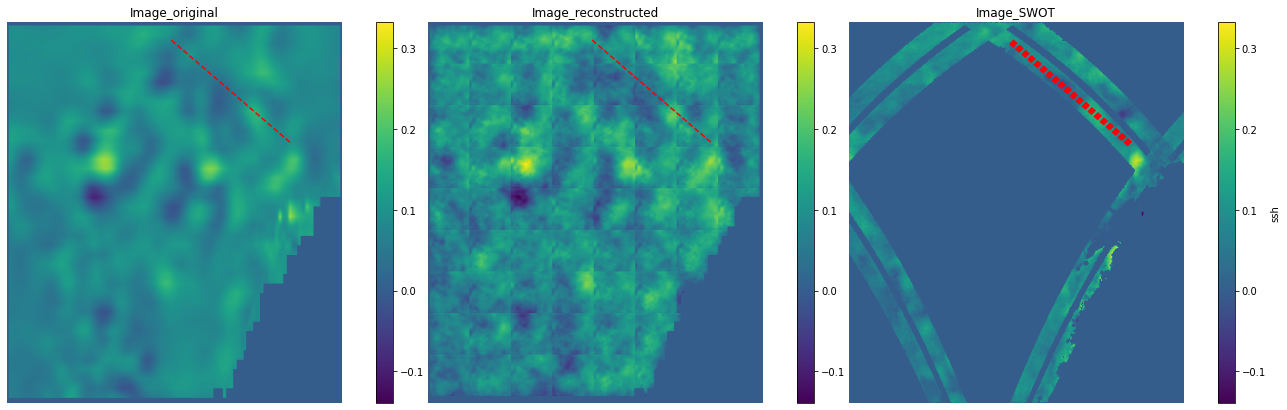

In [63]:
start_point = (20, 190)
end_point = (140, 330)
shift = -1
nb_lines = 5
starts = [(start_point[0] - i*shift, start_point[1] + i*shift) for i in range(1, nb_lines)]
ends = [(end_point[0] - i*shift, end_point[1] + i*shift) for i in range(1, nb_lines)]

Image_original = X_eval
Image_reconstructed = reconstructed_image
Image_SWOT = SWOT_eval

fig = plt.figure(figsize=(22, 7))
# Create a GridSpec with 2 columns and room for the colorbar
gs = GridSpec(1, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.2)

vmin = np.min(reconstructed_image)
vmax = np.max(reconstructed_image)

ax1 = fig.add_subplot(gs[0, 0])
cax1 = ax1.imshow(Image_original, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax1.set_title('Image_original')
ax1.axis('off')
ax1.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], color='red', linestyle='--', linewidth=1.5)

# Create the colorbar
cbar_ax = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(cax1, cax=cbar_ax)
cbar.set_label('ssh')

ax2 = fig.add_subplot(gs[0, 2])
cax2 = ax2.imshow(Image_reconstructed, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_title('Image_reconstructed')
ax2.axis('off')
ax2.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], color='red', linestyle='--', linewidth=1.5)

cbar_ax = fig.add_subplot(gs[0, 3])
cbar = fig.colorbar(cax2, cax=cbar_ax)
cbar.set_label('ssh')

ax3 = fig.add_subplot(gs[0, 4])
cax3 = ax3.imshow(Image_SWOT, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax3.set_title('Image_SWOT')
ax3.axis('off')
ax3.set_xticks(np.arange(0, 388, 20), minor=False)  # Major ticks on x-axis
ax3.set_yticks(np.arange(0, 440, 20), minor=False)  # Major ticks on y-axis
# Enable the grid with custom styling
ax3.grid(which='major', color='black', linestyle='-', linewidth=0.5)
ax3.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], color='red', linestyle='--', linewidth=1.5)
for i in range(len(starts)):
    ax3.plot([starts[i][1], ends[i][1]], [starts[i][0], ends[i][0]], color='red', linestyle='--', linewidth=1.5)


cbar_ax = fig.add_subplot(gs[0, 5])
cbar = fig.colorbar(cax3, cax=cbar_ax)
cbar.set_label('ssh')

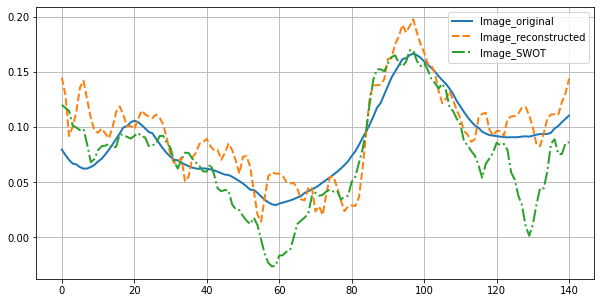

In [64]:
### Plotting of the values along the lines

def extract_line_values(image, start, end):
    rr, cc = line(start[0], start[1], end[0], end[1])
    return image[rr, cc]

values_original = extract_line_values(Image_original, start_point, end_point)
values_reconstructed = extract_line_values(Image_reconstructed, start_point, end_point)
values_SWOT = extract_line_values(Image_SWOT, start_point, end_point)

plt.figure(figsize=(10, 5))
plt.plot(values_original, label='Image_original', linestyle='-', linewidth=2)
plt.plot(values_reconstructed, label='Image_reconstructed', linestyle='--', linewidth=2)
plt.plot(values_SWOT, label='Image_SWOT', linestyle='-.', linewidth=2)
plt.legend()
plt.grid()
plt.show()

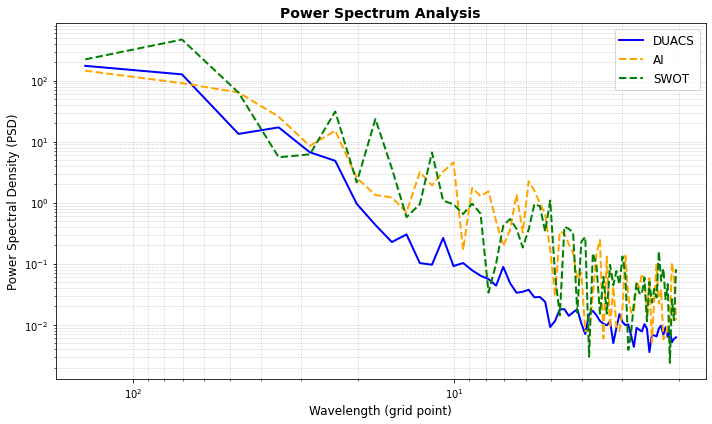

In [70]:
knn, Ann, _ = line_power_spectrum(Image_reconstructed, start_point, end_point)
ktruth, Atruth, _ = line_power_spectrum(Image_SWOT, start_point, end_point)
kval, Aval, line_values = line_power_spectrum(X_eval, start_point, end_point)

normalization = ''
for start, end in zip(starts, ends):
    Ann += line_power_spectrum(Image_reconstructed, start, end, normalization)[1]
    Atruth += line_power_spectrum(Image_SWOT, start, end, normalization)[1]
    Aval += line_power_spectrum(X_eval, start, end, normalization)[1]


Ann /= len(starts) + 1
Atruth /= len(starts) + 1
Aval /= len(starts) + 1
    
npix = line_values.shape[0]

fig, ax = plt.subplots(figsize=(10, 6))

# Plot with enhanced line styles and colors
ax.loglog(npix / kval, Aval, label='DUACS', color='blue', linewidth=2, linestyle='-')
ax.loglog(npix / knn, Ann, label='AI', color='orange', linewidth=2, linestyle='--')
ax.loglog(npix / ktruth, Atruth, label='SWOT', color='green', linewidth=2, linestyle='--')

# Add a grid for better readability of logarithmic scales
ax.grid(True, which="both", linestyle='--', linewidth=0.5, alpha=0.7)

# Add labels, title, and legend
ax.set_xlabel('Wavelength (grid point)', fontsize=12)
ax.set_ylabel('Power Spectral Density (PSD)', fontsize=12)
ax.set_title('Power Spectrum Analysis', fontsize=14, fontweight='bold')
ax.legend(fontsize=12)

ax.tick_params(axis='both', which='major', labelsize=10)
ax.invert_xaxis()  # Invert x-axis as per the original

# Display the plot
plt.tight_layout()
plt.show()

### RMSE

##### for one output of the GAN

In [29]:
mask = total_mask[date_eval, :]  # Extract the mask
valid_pixels = mask == 1  # Create a boolean mask where mask == 1

# Select pixels in the valid region
reconstructed_valid = reconstructed_image[valid_pixels]
SWOT_valid = SWOT_eval[valid_pixels]
X_eval_valid = X_eval[valid_pixels]

# Compute the RMSE
rmse_ai = np.sqrt(np.mean((reconstructed_valid - SWOT_valid) ** 2))
rmse_duacs = np.sqrt(np.mean((X_eval_valid - SWOT_valid) ** 2))

print(f"RMSE AI: {rmse_ai:.4f}")
print(f"RMSE DUACS: {rmse_duacs:.4f}")

relative_change_rmse = (rmse_ai - rmse_duacs) / rmse_duacs
print(f"Relative change in RMSE: {relative_change_rmse * 100:.2f}%")

RMSE AI: 0.0427
RMSE DUACS: 0.0288
Relative change in RMSE: 48.20%


##### For an average of several outputs of the GAN

In [87]:
nb_samples = 30
reconstructed_images_array = np.zeros((*reconstructed_image.shape,nb_samples))

for sample in range(nb_samples):
    patch_input_size = 96
    patch_prediction_size = 48
    diff_size = patch_input_size - patch_prediction_size
    half_diff_size = diff_size//2
    X_eval_padded = np.pad(X_eval, ((half_diff_size, half_diff_size), (half_diff_size, half_diff_size)), mode='constant', constant_values=0)

    reconstructed_image = np.zeros(X_eval_padded.shape)

    # Prepare a list to store patches and their positions
    patches = []
    positions = []

    # Loop through the image and extract patches
    for i in range(half_diff_size, X_eval_padded.shape[0] - half_diff_size - patch_prediction_size + 1, patch_prediction_size):
        for j in range(half_diff_size, X_eval_padded.shape[1] - half_diff_size - patch_prediction_size + 1, patch_prediction_size):
            patch = X_eval_padded[i - half_diff_size: i + patch_prediction_size + half_diff_size, j - half_diff_size: j + patch_prediction_size + half_diff_size] # CONTEXT PATCH
            patches.append(patch)
            positions.append((i, j))  # Save top-left corner position

    # Convert patches to a NumPy array (assuming the model expects a batch of 4D input)
    patches = np.stack(patches)  # Shape: (batch_size, patch_input_size, patch_input_size)

    # Do batch prediction
    predicted_patches = plots.predict_images(gen, noise_gen, patches)  # Use batch prediction function

    # Reconstruct the image from predicted patches
    for (i, j), predicted_patch in zip(positions, predicted_patches):
        reconstructed_image[i : i + patch_prediction_size, j : j + patch_prediction_size] = predicted_patch[:, :, 0]

    reconstructed_image = reconstructed_image[half_diff_size: -half_diff_size, half_diff_size: -half_diff_size]
    reconstructed_image[~sla_mask[0,:]] = 0
    reconstructed_images_array[...,sample] = reconstructed_image
    
reconstructed_image_mean = np.mean(reconstructed_images_array, axis=-1)

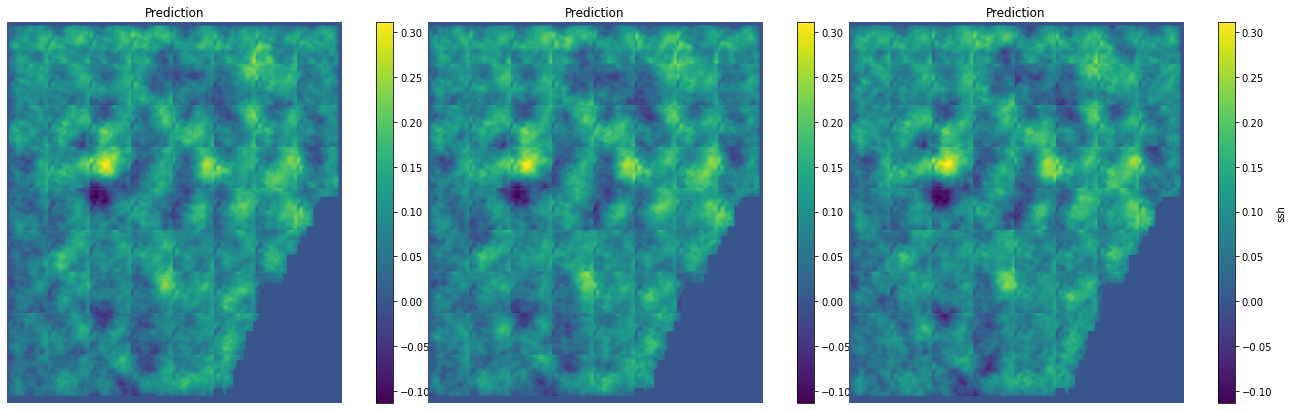

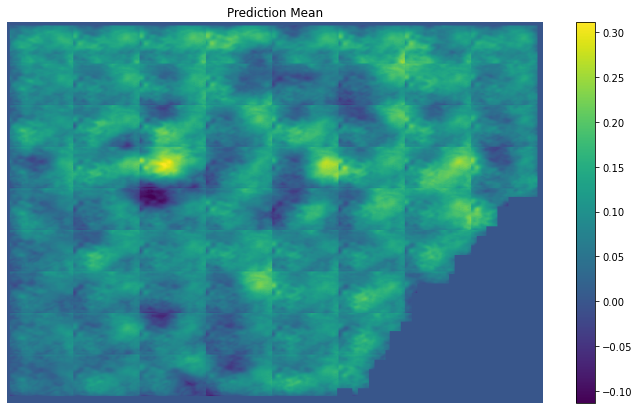

In [88]:
fig = plt.figure(figsize=(22, 7))
# Create a GridSpec with 2 columns and room for the colorbar
gs = GridSpec(1, 6, width_ratios=[1, 0.05, 1, 0.05, 1, 0.05], wspace=0.2)

vmin = np.min(reconstructed_image)
vmax = np.max(reconstructed_image)

ax1 = fig.add_subplot(gs[0, 0])
cax1 = ax1.imshow(reconstructed_images_array[...,0], cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax1.set_title('Prediction')
ax1.axis('off')

# Create the colorbar
cbar_ax = fig.add_subplot(gs[0, 1])
cbar = fig.colorbar(cax1, cax=cbar_ax)
cbar.set_label('ssh')

ax2 = fig.add_subplot(gs[0, 2])
cax2 = ax2.imshow(reconstructed_images_array[...,1], cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax2.set_title('Prediction')
ax2.axis('off')

cbar_ax = fig.add_subplot(gs[0, 3])
cbar = fig.colorbar(cax2, cax=cbar_ax)
cbar.set_label('ssh')

ax3 = fig.add_subplot(gs[0, 4])
cax3 = ax3.imshow(reconstructed_images_array[...,2], cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax3.set_title('Prediction')
ax3.axis('off')


cbar_ax = fig.add_subplot(gs[0, 5])
cbar = fig.colorbar(cax3, cax=cbar_ax)
cbar.set_label('ssh')

fig, ax1 = plt.subplots(figsize=(12, 7))
cax1 = ax1.imshow(reconstructed_image_mean, cmap='viridis', aspect='auto', vmin=vmin, vmax=vmax)
ax1.set_title('Prediction Mean')
ax1.axis('off')
fig.colorbar(cax1, ax=ax1)

In [89]:
mask = total_mask[date_eval, :]  # Extract the mask
valid_pixels = mask == 1  # Create a boolean mask where mask == 1

# Select pixels in the valid region
reconstructed_valid = reconstructed_image_mean[valid_pixels]
SWOT_valid = SWOT_eval[valid_pixels]
X_eval_valid = X_eval[valid_pixels]

# Compute the RMSE
rmse_ai = np.sqrt(np.mean((reconstructed_valid - SWOT_valid) ** 2))
rmse_duacs = np.sqrt(np.mean((X_eval_valid - SWOT_valid) ** 2))

print(f"RMSE AI: {rmse_ai:.4f}")
print(f"RMSE DUACS: {rmse_duacs:.4f}")

relative_change_rmse = (rmse_ai - rmse_duacs) / rmse_duacs
print(f"Relative change in RMSE: {relative_change_rmse * 100:.2f}%")

RMSE AI: 0.0407
RMSE DUACS: 0.0288
Relative change in RMSE: 41.23%
